In [1]:
# Import needed files and basic setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import data_gen2
import tropical

from ipywidgets import Output
from IPython.display import display, Markdown, Latex, Math, clear_output

from sklearn import neighbors

import math

from cvxopt import solvers, matrix

import time

import scipy

%matplotlib notebook
#plt.ion()

In [2]:
npzfile = np.load('parameters.npz')

A1 = npzfile['A1']
b1 = npzfile['b1']
A2 = npzfile['A2']
b2 = npzfile['b2']

In [3]:
npzfile = np.load('binaryFeatures.npz')

binaryFeatures = npzfile['binaryFeatures']
targets = npzfile['targets']

In [4]:
npzfile = np.load('wVecs.npz')

wVecs = npzfile['wVecs']
targets = npzfile['targets']

In [5]:
npzfile = None

In [6]:
def calcHammingDistDistribution(features):
    # Distances
    distances = scipy.spatial.distance.squareform((scipy.spatial.distance.pdist(features, metric='hamming')*128).astype(np.uint8))
    
    # How many of each distance
    dists = []
    for i in range(129):
        if i == 0:
            #print(i, (np.sum(distances == i) - binaryFeatures.shape[0])/2)
            dists.append((np.sum(distances == i) - binaryFeatures.shape[0])//2)
        else:
            #print(i, np.sum(distances == i)/2)
            dists.append(np.sum(distances == i)//2)
            
    # How many connected components
    comps = []
    foundOne = 0
    for i in range(1, 128):
        tempDistances = np.copy(distances)
        tempDistances[tempDistances > i] = 0
        comps.append(scipy.sparse.csgraph.connected_components(tempDistances)[0])
        if comps[-1] == 1:
            foundOne = i
            break
    for i in range(foundOne, 128):
        comps.append(1)
        
    return distances, dists, comps

In [9]:
def calcCosineDistDistribution(features):
    # Distances
    distances = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(features, metric='cosine'))
    
    # How many of each distance
    dists = []
    for j in range(100):
        if j == 0:
            dists.append((np.sum(np.logical_and(j*(2/100) < distances, distances < (j+1)*(2/100))) - distances.shape[0])//2)
        else:
            dists.append(np.sum(np.logical_and(j*(2/100) < distances, distances < (j+1)*(2/100)))//2)
            
    # How many connected components
    comps = []
    foundOne = 0
    for i in range(1, 100):
        tempDistances = np.copy(distances)
        tempDistances[distances > i*(2/100)] = 0
        tempDistances[distances <= i*(2/100)] = 1
        comps.append(scipy.sparse.csgraph.connected_components(tempDistances)[0])
        if comps[-1] == 1:
            foundOne = i
            break
    for i in range(foundOne, 100):
        comps.append(1)
        
    return distances, dists, comps

<IPython.core.display.Javascript object>


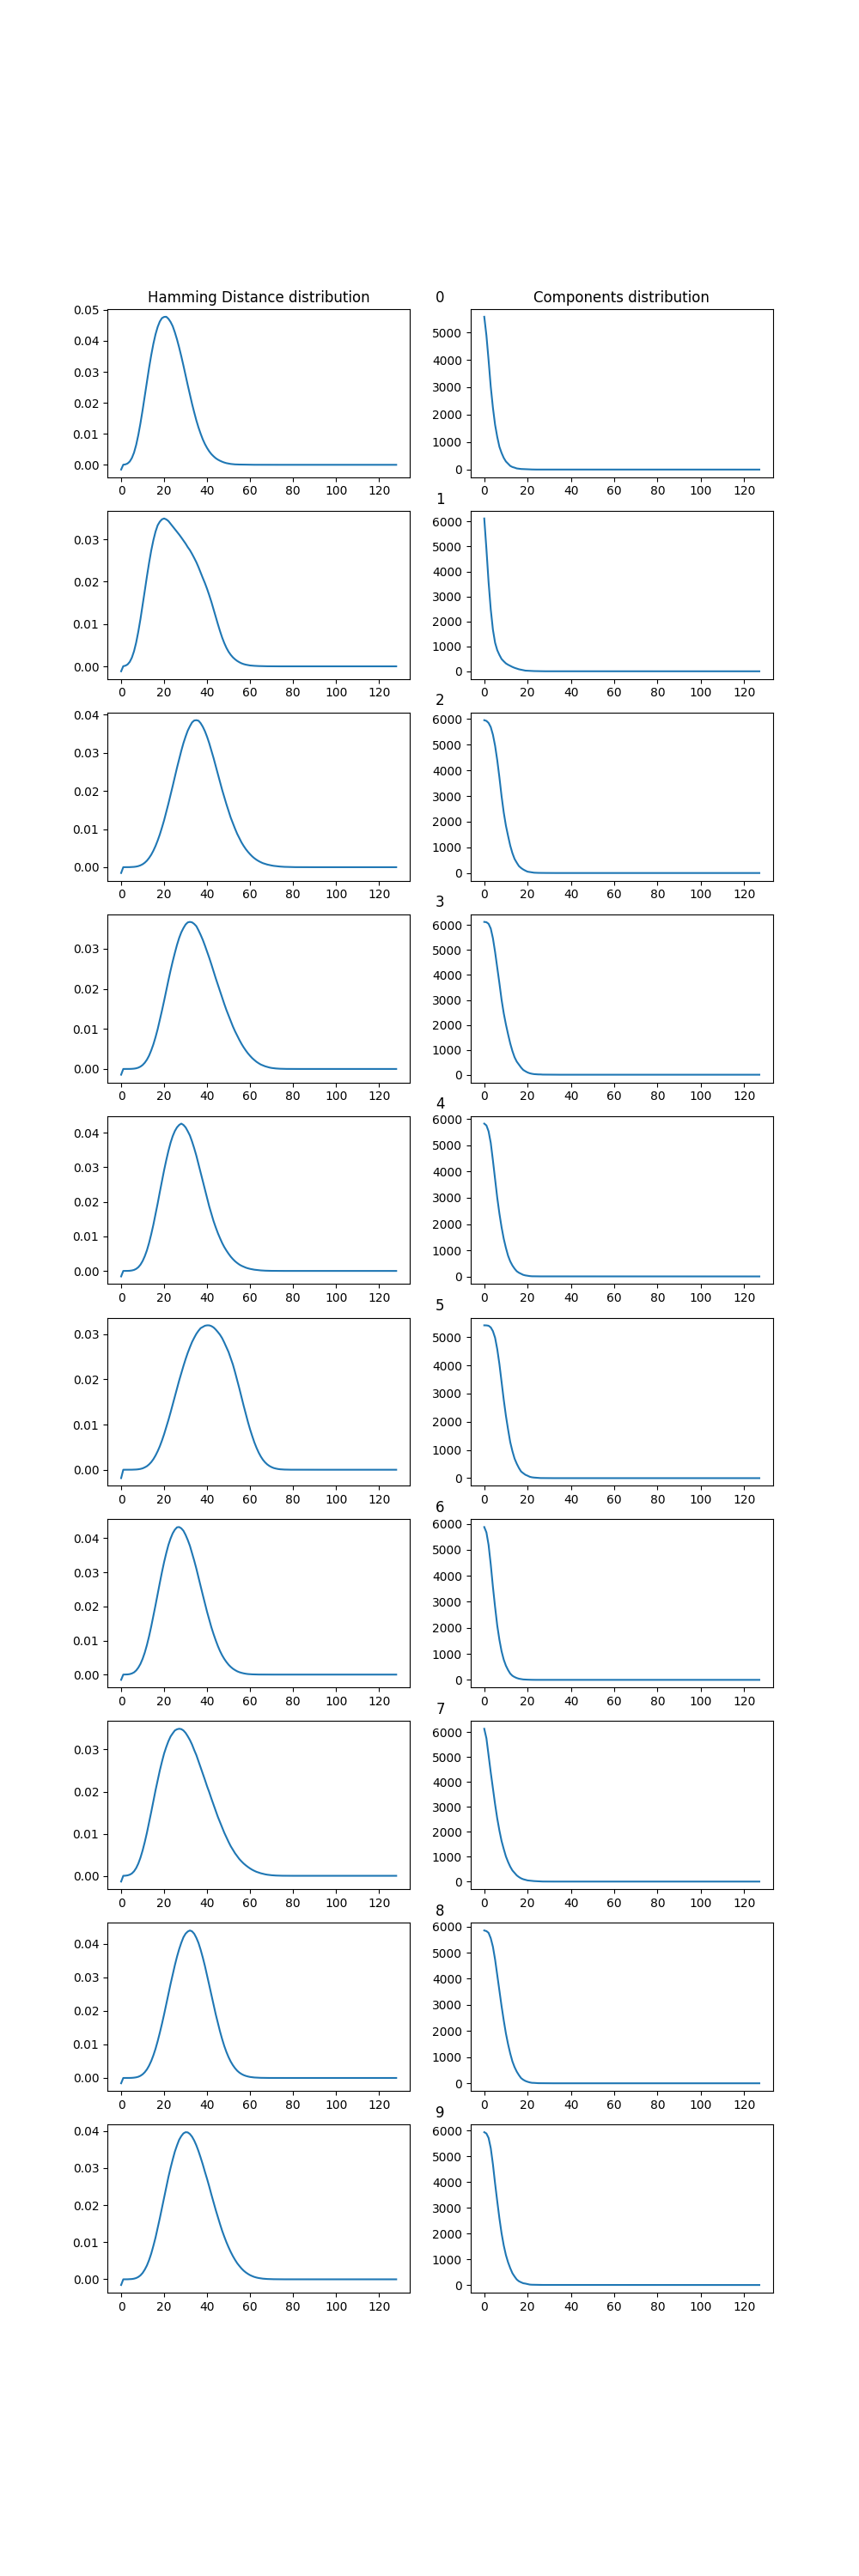

0:	 mean: 22.386270264671023	 median: 22.0	 max: 69	 min: 1
1:	 mean: 26.290450789496077	 median: 25.0	 max: 80	 min: 1
2:	 mean: 36.154774706373054	 median: 36.0	 max: 91	 min: 1
3:	 mean: 34.755386532835885	 median: 34.0	 max: 87	 min: 1
4:	 mean: 29.77592135524536	 median: 29.0	 max: 82	 min: 1
5:	 mean: 40.44144994761502	 median: 40.0	 max: 88	 min: 1
6:	 mean: 28.21706307025119	 median: 28.0	 max: 76	 min: 1
7:	 mean: 30.217072742895105	 median: 29.0	 max: 84	 min: 1
8:	 mean: 32.25725899079695	 median: 32.0	 max: 79	 min: 1
9:	 mean: 32.21811712098362	 median: 32.0	 max: 82	 min: 1


In [11]:
# Plot distributions
fig = plt.figure(figsize=(10, 30))
fig.tight_layout()

axFull = fig.add_subplot(1, 2, 1)
axFull.set_title('Hamming Distance distribution')
axFull.set_axis_off()
axFull = fig.add_subplot(1, 2, 2)
axFull.set_title('Components distribution')
axFull.set_axis_off()

for i in range(10):
    axFull = fig.add_subplot(10, 1, i+1)
    ax1 = fig.add_subplot(10, 2, i*2+1)
    ax2 = fig.add_subplot(10, 2, i*2+2)
    
    distances, dists, comps = calcHammingDistDistribution(binaryFeatures[targets.ravel() == i, :])
    
    print("{}:\t mean: {}\t median: {}\t max: {}\t min: {}".format(i, np.mean(distances), np.median(distances), np.amax(distances), np.amin(distances[distances > 0])))
    
    ax1.plot(dists/sum(dists))
    ax2.plot(comps)
    axFull.set_title('{}'.format(i))
    axFull.set_axis_off()
    fig.canvas.draw()
    fig.canvas.flush_events()

<IPython.core.display.Javascript object>


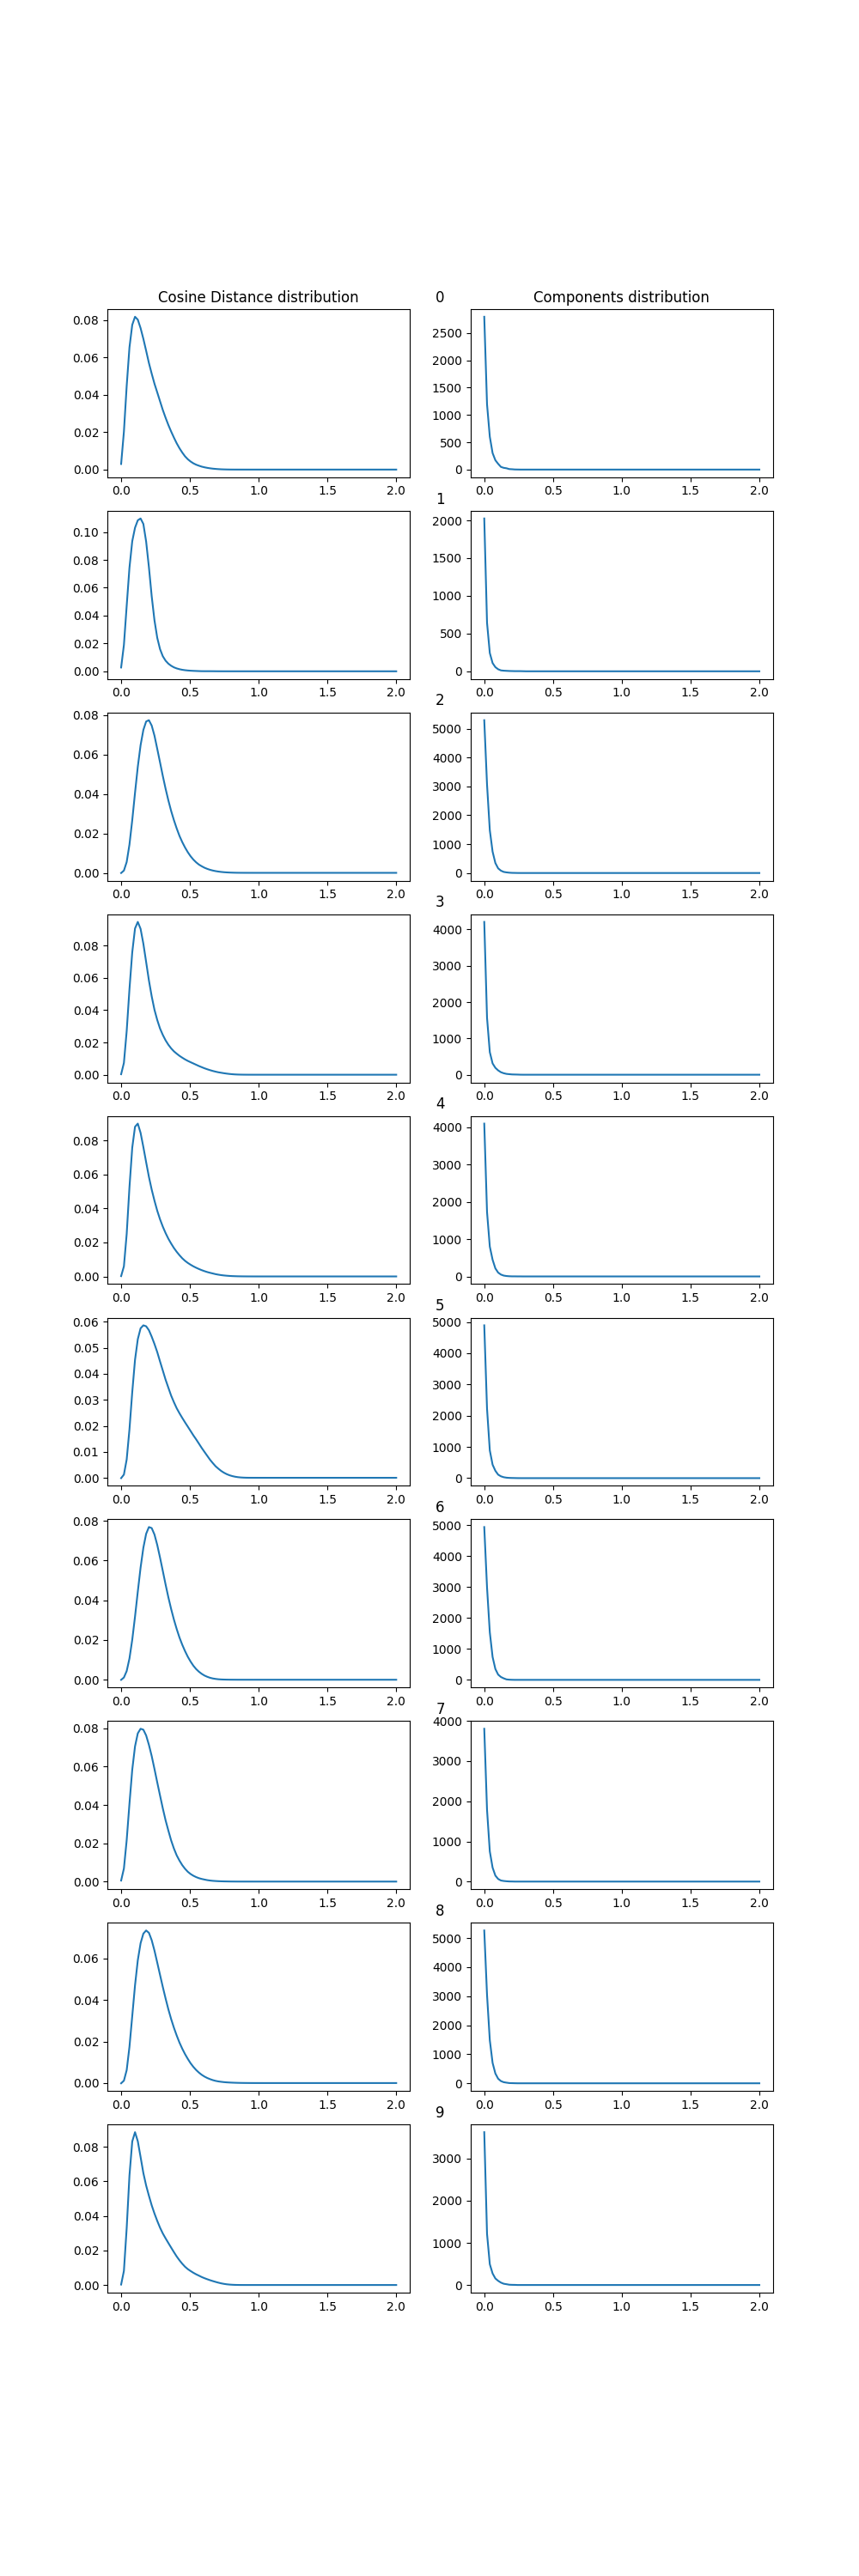

0:	 mean: 0.1987109121645936	 median: 0.17455837374048533	 max: 0.9483716511190715	 min: 1.1102230246251565e-16
1:	 mean: 0.15625694730742326	 median: 0.14944964524757293	 max: 0.8931608728228604	 min: 1.1102230246251565e-16
2:	 mean: 0.25691253284027243	 median: 0.23793767998559384	 max: 1.0013012677822932	 min: 0.0004643192712269206
3:	 mean: 0.21291674599004592	 median: 0.17461510469349462	 max: 0.9956794138175932	 min: 0.0015906645553458443
4:	 mean: 0.21414599395247153	 median: 0.1805373791508736	 max: 1.046748892991832	 min: 6.780314622112371e-05
5:	 mean: 0.29361357636505664	 median: 0.26167602957746683	 max: 1.065274686953083	 min: 0.00422432306876408
6:	 mean: 0.26559012824189976	 median: 0.25012827685557465	 max: 0.9928965709387976	 min: 0.0002945302240477954
7:	 mean: 0.21409645634444593	 median: 0.19695305106851713	 max: 1.0674780236958854	 min: 1.1102230246251565e-16
8:	 mean: 0.2567372465769692	 median: 0.23497840461505248	 max: 1.0700085178571346	 min: 0.0012177643044526

In [16]:
# Plot distributions
fig = plt.figure(figsize=(10, 30))
fig.tight_layout()

axFull = fig.add_subplot(1, 2, 1)
axFull.set_title('Cosine Distance distribution')
axFull.set_axis_off()
axFull = fig.add_subplot(1, 2, 2)
axFull.set_title('Components distribution')
axFull.set_axis_off()

for i in range(10):
    axFull = fig.add_subplot(10, 1, i+1)
    ax1 = fig.add_subplot(10, 2, i*2+1)
    ax2 = fig.add_subplot(10, 2, i*2+2)
    
    distances, dists, comps = calcCosineDistDistribution(wVecs[targets.ravel() == i, :])
    
    print("{}:\t mean: {}\t median: {}\t max: {}\t min: {}".format(i, np.mean(distances), np.median(distances), np.amax(distances), np.amin(distances[distances > 0])))
    
    ax1.plot(np.linspace(0, 2, 100), dists/sum(dists))
    ax2.plot(np.linspace(0, 2, 100), comps)
    axFull.set_title('{}'.format(i))
    axFull.set_axis_off()
    fig.canvas.draw()
    fig.canvas.flush_events()

<IPython.core.display.Javascript object>


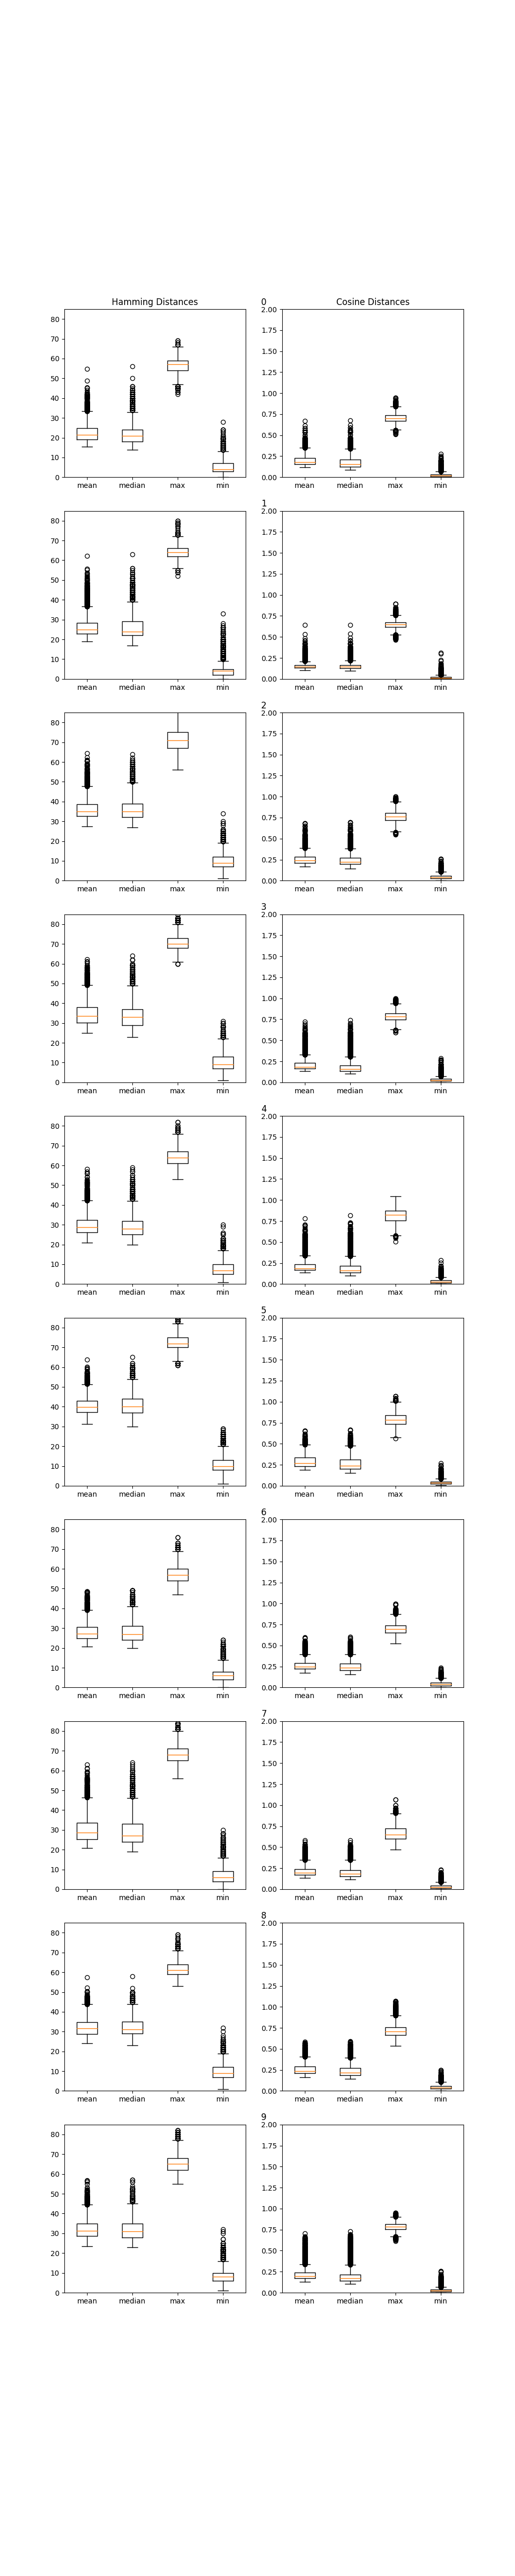

In [15]:
# Plot box and whiskers
fig = plt.figure(figsize=(10, 50))
axFull = fig.add_subplot(1, 2, 1)
axFull.set_title('Hamming Distances')
axFull.set_axis_off()
axFull = fig.add_subplot(1, 2, 2)
axFull.set_title('Cosine Distances')
axFull.set_axis_off()
for i in range(10):
    axFull = fig.add_subplot(10, 1, i+1)
    axFull.set_title('{}'.format(i))
    axFull.set_axis_off()
    
    ax = fig.add_subplot(10, 2, 2*i + 1)
    distances = scipy.spatial.distance.squareform((scipy.spatial.distance.pdist(binaryFeatures[targets.ravel() == i, :], metric='hamming')*128).astype(np.uint8))
    indices = np.eye(distances.shape[0], dtype=bool)
    
    means = np.mean(distances, axis=0)
    medians = np.median(distances, axis=0)
    maxs = np.amax(distances, axis=0)
    distances[indices] = 129
    mins = np.amin(distances, axis=0)
    ax.boxplot([means, medians, maxs, mins])
    ax.set_xticklabels(['mean', 'median', 'max', 'min'])
    #ax.set_title('Class {}'.format(i))
    ax.set_ylim([0, 85])
    
    ax = fig.add_subplot(10, 2, 2*i + 2)
    wVecsClass = wVecs[targets.ravel() == i, :]
    distances = scipy.spatial.distance.squareform((scipy.spatial.distance.pdist(wVecsClass, metric='cosine')))
    
    indices = np.eye(distances.shape[0], dtype=bool)
    means = np.mean(distances, axis=0)
    medians = np.median(distances, axis=0)
    maxs = np.amax(distances, axis=0)
    distances[indices] = 101
    mins = np.amin(distances, axis=0)
    
    #print("{}:\t mean: {}\t median: {}\t max: {}\t min: {}".format(i, np.mean(distances), np.median(distances), np.amax(distances), np.amin(distances[distances > 0])))
    
    ax.boxplot([means, medians, maxs, mins])
    ax.set_xticklabels(['mean', 'median', 'max', 'min'])
    #ax.set_title('Class {}'.format(i))
    ax.set_ylim([0, 2])
    
    fig.canvas.draw()
    fig.canvas.flush_events()